<a href="https://colab.research.google.com/github/JBenedictM/501-A4-TF/blob/master/501_A4_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/heart.csv"
train_path = "/content/drive/My Drive/heart_train.csv"
test_path = "/content/drive/My Drive/heart_test.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Create Train and Test csv files
Splits Heart.csv into 80% training data and 20% testing data

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sys

data = pd.read_csv(data_path)
y_chd = data.chd
X = data.drop("chd", axis=1)
X = X.drop("row.names", axis=1)
#data = data.drop("", axis=1)
#print(X)

x_train, x_test, y_train, y_test = train_test_split(data, y_chd, test_size=0.2)

#print(x_train.shape)
#print(x_train)

#print(x_test.shape)
#print(x_test)

x_train.to_csv("/content/drive/My Drive/heart_train.csv", encoding="utf-8", sep='\t', index=False)
x_test.to_csv("/content/drive/My Drive/heart_test.csv", encoding="utf-8", sep='\t', index=False)

# Load and Process Data

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import tensorflow as tf
import pandas as pd
import sys

PREDICT_COLUMN = "chd"
PREDICT_LABELs = [0, 1]

# load csv data
def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(  
        file_path, 
        label_name=PREDICT_COLUMN,
        batch_size=1,
        na_value="?",
        num_epochs=1,
        ignore_errors=True,
        field_delim='\t',
        **kwargs)
    
    return dataset

def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key, value.numpy()))

def pack(features, label):
    return tf.stack(list(features.values()), axis=-1), label


def normalize_numeric_data(data, mean, std):
    return (data-mean)/std




In [0]:
class PackNumericFeatures(object):
    def __init__(self, names):
        self.names = names

      
    def __call__(self, features, labels):
        numeric_features = [features.pop(name) for name in self.names]
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
        numeric_features = tf.stack(numeric_features, axis=-1)
        features["numeric"] = numeric_features

        return features, labels


In [36]:
# instaniate training and testing data

import pathlib
import shutil
import tempfile

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

NAME_COLUMN = "row.names"
SELECT_COLUMNS =  ["sbp", "tobacco", "ldl", "adiposity", "famhist", "typea", "obesity", "alcohol", "age"] + [PREDICT_COLUMN]
NUMERIC_COLUMNS = ["sbp", "tobacco", "ldl", "adiposity", "typea", "obesity", "alcohol", "age"]
SELECT_COLUMNS_NUM = NUMERIC_COLUMNS + [PREDICT_COLUMN]
DEFAULT_NUM = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

data_sample_size = 462
train_sample_size = int(data_sample_size*0.8)
test_sample_size = data_sample_size - train_sample_size
BATCH_SIZE = 10
STEPS_PER_EPOCH = train_sample_size//BATCH_SIZE

print(train_sample_size)
print(test_sample_size)

raw_train_data = get_dataset(train_path, select_columns=SELECT_COLUMNS).repeat().batch(BATCH_SIZE)
raw_test_data = get_dataset(test_path, select_columns=SELECT_COLUMNS).batch(BATCH_SIZE)

#show_batch(raw_train_data)
#print()
#show_batch(raw_test_data)

# pack numeric data types
#temp_train_numeric = get_dataset(train_path, select_columns=SELECT_COLUMNS_NUM, column_defaults=DEFAULT_NUM)
#show_batch(temp_train_numeric)
#print(len(list(raw_test_data)))

#example_batch, labels_batch = next(iter(temp_train_numeric))

#packed_dataset = temp_train_numeric.map(pack)

#for features, label in packed_dataset.take(1):
 #   print(features.numpy())
  #  print()
   # print(label.numpy())

packed_train_data = raw_train_data.map(PackNumericFeatures(NUMERIC_COLUMNS))
packed_test_data = raw_test_data.map(PackNumericFeatures(NUMERIC_COLUMNS))
show_batch(packed_train_data)

example_batch, labels_batch = next(iter(packed_train_data))
print(example_batch)

# normalize data
# load data and calculate mean and standard deviation of training data
#desc = pd.read_csv(train_path, names=SELECT_COLUMNS, index_col=SELECT_COLUMNS, usecols=NUMERIC_COLUMNS, sep='\t')
desc = pd.read_csv(train_path, sep='\t')[NUMERIC_COLUMNS].describe()
print(desc)
MEAN = np.array(desc.T["mean"])
STD = np.array(desc.T["std"])

#sys.exit(1)

normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)

numeric_column = tf.feature_column.numeric_column("numeric", normalizer_fn=normalizer, shape=[len(NUMERIC_COLUMNS)])
numeric_columns = [numeric_column]
#print("Before")
#print(example_batch["numeric"])

numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
#print("After")
#print(numeric_layer(example_batch).numpy())

# enumerate categorical columns
CATEGORIES = {
    "famhist" : ["Absent", "Present"]
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(  
              key=feature, vocabulary_list=vocab)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))

#categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
#print(categorical_layer(example_batch).numpy())
#sys.exit(0)

preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns + numeric_columns)
print(preprocessing_layer(example_batch).numpy())
#print(labels_batch)

train_data = packed_train_data.shuffle(500)
#train_data = preprocessing_layer(.numpy())
test_data = packed_test_data



        

369
93
famhist             : [[b'Absent']
 [b'Present']
 [b'Absent']
 [b'Present']
 [b'Absent']
 [b'Absent']
 [b'Absent']
 [b'Absent']
 [b'Absent']
 [b'Present']]
numeric             : [[[118.     5.4   11.61  30.79  64.    27.35  23.97  40.  ]]

 [[178.     5.5    3.79  23.92  45.    21.26   6.17  62.  ]]

 [[166.     0.8    5.63  36.21  50.    34.72  28.8   60.  ]]

 [[136.     3.46   6.38  32.25  43.    28.73   3.13  43.  ]]

 [[170.     0.     3.12  37.15  47.    35.42   0.    53.  ]]

 [[124.     0.81   6.16  11.61  35.    21.47  10.49  26.  ]]

 [[134.     0.     5.63  29.12  68.    32.33   2.02  34.  ]]

 [[128.     2.6    4.94  21.36  61.    21.3    0.    31.  ]]

 [[132.     2.     3.08  35.39  45.    31.44  79.82  58.  ]]

 [[128.     0.    10.58  31.81  46.    28.41  14.66  48.  ]]]
OrderedDict([('famhist', <tf.Tensor: id=305880, shape=(10, 1), dtype=string, numpy=
array([[b'Present'],
       [b'Absent'],
       [b'Present'],
       [b'Present'],
       [b'Present'],
       

# Create and Train Model

# Base Model

--Fit model--
Train for 36 steps
        52.90514905,  26.04127371,  17.70642276,  43.55555556]), std=array([21.26571252,  4.75853044,  2.09918096,  7.56312   , 10.22035483,
        4.09612605, 25.53965407, 14.5910849 ])))
Epoch 1/99999999999
29/36 [=======================>......] - ETA: 0s - loss: 0.5648 - accuracy: 0.6966 - binary_crossentropy: 0.5648
Epoch 00001: val_accuracy improved from -inf to 0.72043, saving model to /content/drive/My Drive/base_model_heart/base_heart_model.ckpt
36/36 [==============================] - 2s 42ms/step - loss: 0.5449 - accuracy: 0.7194 - binary_crossentropy: 0.5449 - val_loss: 0.5027 - val_accuracy: 0.7204 - val_binary_crossentropy: 0.5175
Epoch 2/99999999999
 1/10 [==>...........................] - ETA: 0s - loss: 0.5636 - accuracy: 0.5000 - binary_crossentropy: 0.5636
Epoch 00002: val_accuracy improved from 0.72043 to 0.75269, saving model to /content/drive/My Drive/base_model_heart/base_heart_model.ckpt
36/10 [===================================

(0.4, 1.0)

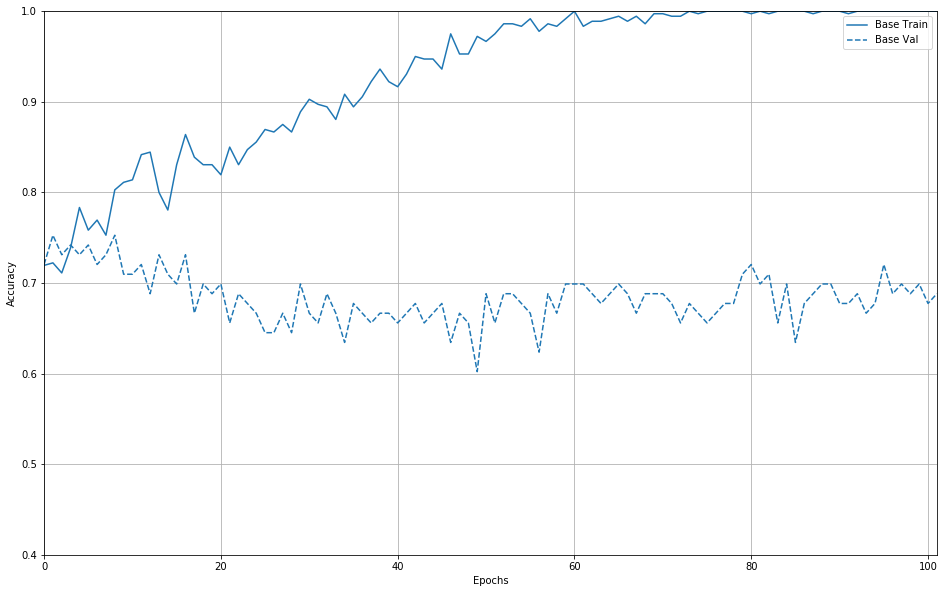

In [38]:
def create_base_model():
    model = tf.keras.Sequential([
      preprocessing_layer,
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                  0.001,
                  decay_steps=STEPS_PER_EPOCH*1000,
                  decay_rate=1,
                  staircase=False)
    

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        metrics=["accuracy", "binary_crossentropy"]
    )

    

    return model


train_model = create_base_model()
base_model_path = "/content/drive/My Drive/base_model_heart/base_heart_model.ckpt"


# train model
print("--Fit model--")
val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=100, min_delta=0.001)
checkpoint_val = tf.keras.callbacks.ModelCheckpoint(base_model_path, monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)
log_name = "sizes/Base"
tb_log = tf.keras.callbacks.TensorBoard(logdir/log_name)
#checkpoint_train = tf.keras.callbacks.ModelCheckpoint("base_heart_model.h5", monitor="loss", mode="min", save_best_only=True, save_weights_only=True, verbose=1)
cb = [val_loss_callback, checkpoint_val, tb_log]

train_history = train_model.fit(
    train_data,
    epochs=99999999999, 
    verbose=1, 
    validation_data=test_data, 
    callbacks=cb,
    steps_per_epoch=STEPS_PER_EPOCH)

model_histories = {}
model_histories["Base"] = train_history

plotter = tfdocs.plots.HistoryPlotter(metric='accuracy')
plotter.plot(model_histories)
plt.ylim([0.4, 1.0])



# Model with l2 regularizer

--Fit model--
Train for 36 steps
        52.90514905,  26.04127371,  17.70642276,  43.55555556]), std=array([21.26571252,  4.75853044,  2.09918096,  7.56312   , 10.22035483,
        4.09612605, 25.53965407, 14.5910849 ])))
Epoch 1/99999999999
31/36 [========================>.....] - ETA: 0s - loss: 0.8602 - accuracy: 0.6645 - binary_crossentropy: 0.6059
Epoch 00001: val_accuracy improved from -inf to 0.73118, saving model to /content/drive/My Drive/l2_model_heart/l2_heart_model.ckpt
36/36 [==============================] - 2s 55ms/step - loss: 0.8373 - accuracy: 0.6750 - binary_crossentropy: 0.5857 - val_loss: 0.7628 - val_accuracy: 0.7312 - val_binary_crossentropy: 0.5198
Epoch 2/99999999999
 9/10 [==========================>...] - ETA: 0s - loss: 0.8063 - accuracy: 0.6778 - binary_crossentropy: 0.5785
Epoch 00002: val_accuracy improved from 0.73118 to 0.75269, saving model to /content/drive/My Drive/l2_model_heart/l2_heart_model.ckpt
36/10 [===========================================

(0.4, 1.0)

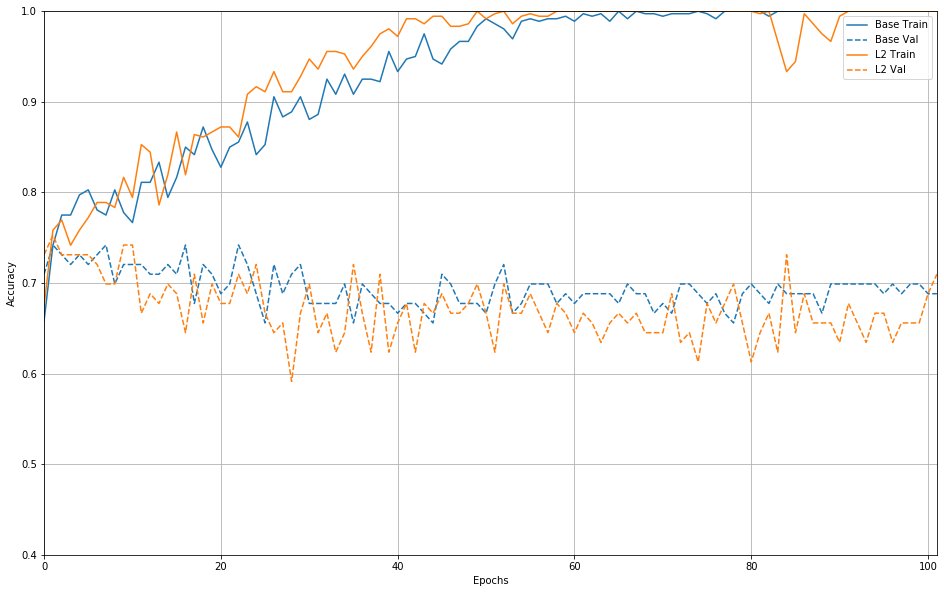

In [9]:
from tensorflow.keras import regularizers

def create_l2_model():
    model = tf.keras.Sequential([
      preprocessing_layer,
      tf.keras.layers.Dense(128, activation="relu",
                            kernel_regularizer=regularizers.l2(0.001)),
      tf.keras.layers.Dense(128, activation="relu",
                            kernel_regularizer=regularizers.l2(0.001)),   
      tf.keras.layers.Dense(128, activation="relu",
                            kernel_regularizer=regularizers.l2(0.001)),                                   
      tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                  0.001,
                  decay_steps=STEPS_PER_EPOCH*1000,
                  decay_rate=1,
                  staircase=False)

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        metrics=["accuracy", "binary_crossentropy"]
    )

    return model


train_model = create_l2_model()
l2_model_path = "/content/drive/My Drive/l2_model_heart/l2_heart_model.ckpt"


# train model
print("--Fit model--")
val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=100, min_delta=0.001)
checkpoint_val = tf.keras.callbacks.ModelCheckpoint(l2_model_path, monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)
log_name = "sizes/l2"
tb_log = tf.keras.callbacks.TensorBoard(logdir/log_name)
#checkpoint_train = tf.keras.callbacks.ModelCheckpoint("base_heart_model.h5", monitor="loss", mode="min", save_best_only=True, save_weights_only=True, verbose=1)
cb = [val_loss_callback, checkpoint_val, tb_log]

train_history = train_model.fit(
    train_data,
    epochs=99999999999, 
    verbose=1, 
    validation_data=test_data, 
    callbacks=cb,
    steps_per_epoch=STEPS_PER_EPOCH)

#model_histories = {}
model_histories["l2"] = train_history

plotter = tfdocs.plots.HistoryPlotter(metric='accuracy')
plotter.plot(model_histories)
plt.ylim([0.4, 1.0])

# Model with l2 regularizer and dropout layers

--Fit model--
Train for 36 steps
        52.90514905,  26.04127371,  17.70642276,  43.55555556]), std=array([21.26571252,  4.75853044,  2.09918096,  7.56312   , 10.22035483,
        4.09612605, 25.53965407, 14.5910849 ])))
Epoch 1/99999999999
32/36 [=========================>....] - ETA: 0s - loss: 1.3622 - accuracy: 0.6344 - binary_crossentropy: 0.6324
Epoch 00001: val_accuracy improved from -inf to 0.74194, saving model to /content/drive/My Drive/l2_dropout_model_heart_v3/l2_dropout_heart_model_v3.ckpt
36/36 [==============================] - 2s 64ms/step - loss: 1.3521 - accuracy: 0.6389 - binary_crossentropy: 0.6260 - val_loss: 1.2419 - val_accuracy: 0.7419 - val_binary_crossentropy: 0.5324
Epoch 2/99999999999
 9/10 [==========================>...] - ETA: 0s - loss: 1.2892 - accuracy: 0.7333 - binary_crossentropy: 0.6001
Epoch 00002: val_accuracy did not improve from 0.74194
36/10 [=====================================================================================================

(0.4, 1.0)

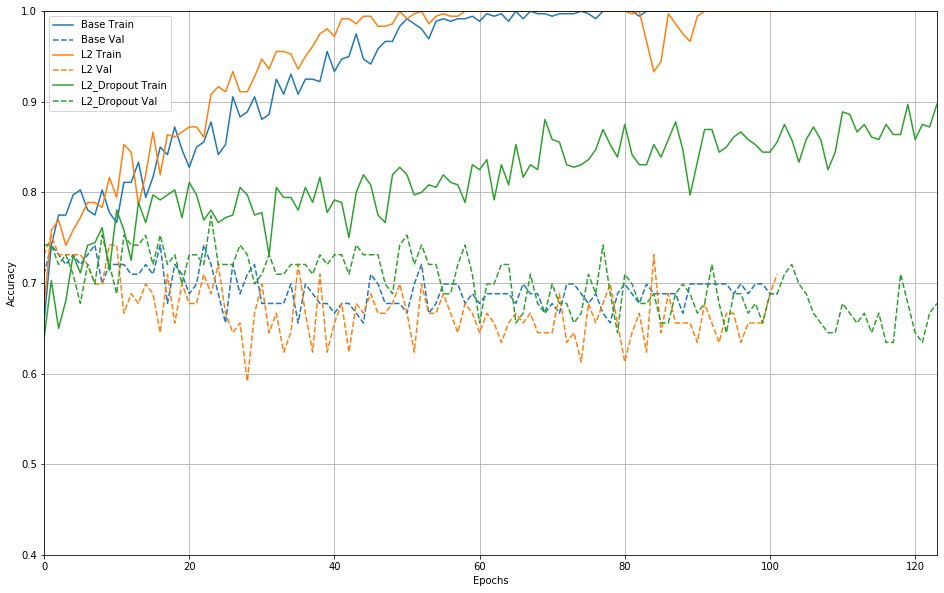

In [16]:
from tensorflow.keras import regularizers

def create_l2_dropout_model():
    model = tf.keras.Sequential([
      preprocessing_layer,
      tf.keras.layers.Dense(256, activation="relu",
                            kernel_regularizer=regularizers.l2(0.001)),
      tf.keras.layers.Dropout(0.50),

      tf.keras.layers.Dense(256, activation="relu",
                            kernel_regularizer=regularizers.l2(0.001)), 
      tf.keras.layers.Dropout(0.50),

      tf.keras.layers.Dense(256, activation="relu",
                            kernel_regularizer=regularizers.l2(0.001)), 
      tf.keras.layers.Dropout(0.50),

      tf.keras.layers.Dense(256, activation="relu",
                            kernel_regularizer=regularizers.l2(0.001)), 
      tf.keras.layers.Dropout(0.50),

      tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                  0.001,
                  decay_steps=STEPS_PER_EPOCH*1000,
                  decay_rate=1,
                  staircase=False)

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        metrics=["accuracy", "binary_crossentropy"]
    )

    return model


train_model = create_l2_dropout_model()
l2_dropout_model_path = "/content/drive/My Drive/l2_dropout_model_heart_v3/l2_dropout_heart_model_v3.ckpt"


# train model
print("--Fit model--")
val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=100, min_delta=0.001)
checkpoint_val = tf.keras.callbacks.ModelCheckpoint(l2_dropout_model_path, monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=True, verbose=1)
log_name = "sizes/l2_dropout"
tb_log = tf.keras.callbacks.TensorBoard(logdir/log_name)
#checkpoint_train = tf.keras.callbacks.ModelCheckpoint("base_heart_model.h5", monitor="loss", mode="min", save_best_only=True, save_weights_only=True, verbose=1)
cb = [val_loss_callback, checkpoint_val, tb_log]

train_history = train_model.fit(
    train_data,
    epochs=99999999999, 
    verbose=1, 
    validation_data=test_data, 
    callbacks=cb,
    steps_per_epoch=STEPS_PER_EPOCH)

#model_histories = {}
model_histories["l2_dropout"] = train_history

plotter = tfdocs.plots.HistoryPlotter(metric='accuracy')
plotter.plot(model_histories)
plt.ylim([0.4, 1.0])

In [0]:
# *** DOES NOT WORK; INPUT ERROR?? ***
# load base model and evaluate
load_model = create_base_model()

load_model.load_weights(base_model_path)
test_loss, test_accuracy = load_model.evaluate(test_data)
#load_model.summary()
#print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))